# **1. Global Constants**

In [1]:
import itertools
import keras
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, det_curve, auc
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay 

from keras.preprocessing import image

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
load_model = keras.models.load_model('ghostfacenet_v1.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# **2. Dataset**

In [4]:
def get_folders(dataset_path):
    """
    List all the directories (person folders) inside the main dataset directory.
    """
    return [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

def get_images(folder_path):
    """
    Randomly pick and list 5 image files within a specified folder, using a fixed random seed for reproducibility.
    """
    # Pick 5 images at random from the list of all images
    all_images = [file for file in os.listdir(folder_path) if file.endswith('.png')]
    # If there are less than 5 images, it returns all of them
    return random.sample(all_images, min(5, len(all_images)))
    #return [file for file in os.listdir(folder_path) if file.endswith('.png')]

def generate_pairs(dataset_path):
    """
    Generate positive and negative pairs of images and return them as a pandas DataFrame.
    """
    person_folders = get_folders(dataset_path)
    positive_pairs = []
    negative_pairs = []

    # Generate positive pairs
    for folder in person_folders:
        images = get_images(folder)
        for pair in itertools.combinations(images, 2):
            positive_pairs.append((os.path.join(folder, pair[0]), os.path.join(folder, pair[1]), True))
    
    # Generate negative pairs
    all_images = [(folder, image) for folder in person_folders for image in get_images(folder)]
    for _ in range(len(positive_pairs)):  # Assuming we want an equal number of negative pairs
        pair = random.sample(all_images, 2)
        while pair[0][0] == pair[1][0]:  # Ensure pairs are from different folders
            pair = random.sample(all_images, 2)
        negative_pairs.append((os.path.join(pair[0][0], pair[0][1]), os.path.join(pair[1][0], pair[1][1]), False))
    
    # Combine, shuffle, and create a DataFrame
    dataset = positive_pairs + negative_pairs
    random.shuffle(dataset)
    df = pd.DataFrame(dataset, columns=['Image1', 'Image2', 'IsSame'])

    return df

In [5]:
dataset_path = 'dataset'
df_pairs = generate_pairs(dataset_path)
print(df_pairs.head()) 

                Image1               Image2  IsSame
0  dataset/1415/36.png  dataset/1415/22.png    True
1   dataset/309/71.png   dataset/309/34.png    True
2   dataset/310/17.png   dataset/310/39.png    True
3   dataset/880/15.png    dataset/203/8.png   False
4    dataset/213/9.png   dataset/987/54.png   False


In [6]:
print(len(df_pairs))

40000


In [7]:
train_df, test_df = train_test_split(df_pairs, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)

In [8]:
print(len(test_df))

12000


In [9]:
train_df, test_df = train_test_split(test_df, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)

In [10]:
print(len(test_df))

3600


In [11]:
print(len(test_df.loc[test_df['IsSame'] == False]))

1793


# **3. Evaluation**

In [12]:
def cosine_similarity(embedding1, embedding2):
    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()
    # Handle division by zero
    denom = (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    if denom == 0:
        return np.nan  # Return NaN if denominator is zero
    return np.dot(embedding1, embedding2) / denom

In [13]:
def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')
    
    # Normalize the image data to [-1, 1]
    img_array = (img_array / 127.5) - 1  # Assuming the original range is [0, 255]
    return model.predict(np.expand_dims(img_array, axis=0))

In [16]:
def evaluate_model_with_metrics(model, df_pairs):
    scores = []
    true_labels = []

    for index, row in df_pairs.iterrows():
        image_path1 = row['Image1']
        image_path2 = row['Image2']
        
        # Check if paths exist (Debugging)
        if not os.path.exists(image_path1) or not os.path.exists(image_path2):
            print(f"Skipping comparison due to missing image at row {index}: {image_path1}, {image_path2}")
            continue

        embedding1 = get_embedding(model, image_path1)
        embedding2 = get_embedding(model, image_path2)
        
        # Debugging: Check if embeddings are valid
        if embedding1 is None or embedding2 is None:
            print(f"Invalid embeddings at row {index}.")
            continue

        similarity = cosine_similarity(embedding1, embedding2)
        
        # Debugging: Check similarity value
        if np.isnan(similarity):
            print(f"NaN similarity at row {index}.")
            continue

        # If code reaches here, it means a valid score was processed
        scores.append(similarity)
        true_labels.append(row['IsSame'])

    if not scores:
        print("No valid scores to process.")
        return
    
    # Continue with your calculation of FPR, FNR, thresholds, and metrics
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    metrics_by_threshold = {}
    for i, threshold in enumerate(thresholds):
        ga = tpr[i]
        gr = 1 - fpr[i]
        far = fpr[i]
        frr = 1 - tpr[i]

        metrics_by_threshold[threshold] = {
            'FAR': far,
            'FRR': frr,
            'GA (Genuine Acceptance Rate)': ga,
            'GR (Genuine Rejection Rate)': gr,
            'ROC AUC': roc_auc
        }
    return metrics_by_threshold


1/1 [==============================] - 0s 35ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


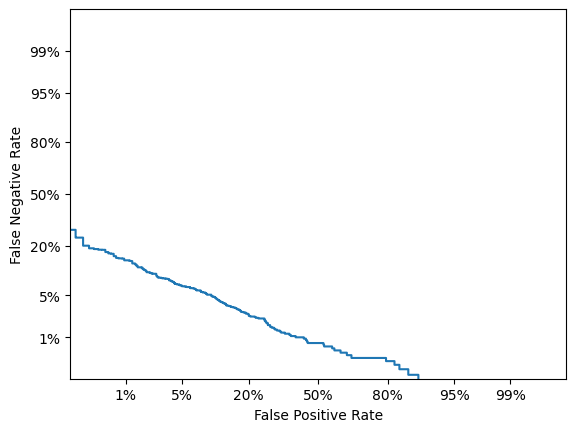

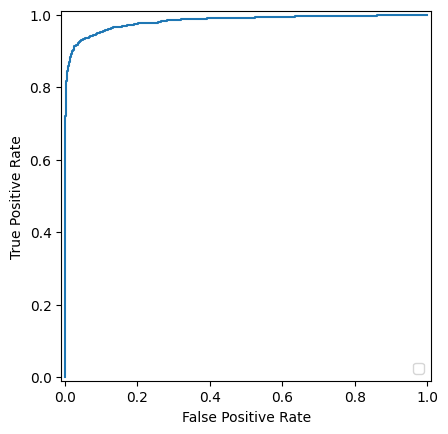

In [15]:
result = evaluate_model_with_metrics(load_model, test_df)

# **4. Plot**

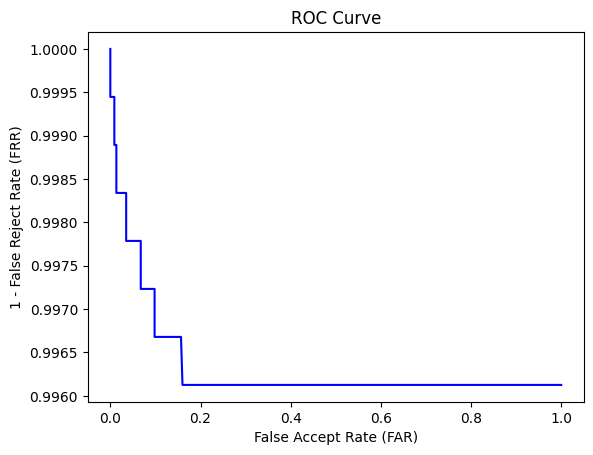

In [18]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt


# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = [result[score]['FAR'] for score in result]
frrs = [1-result[score]['FRR'] for score in result]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

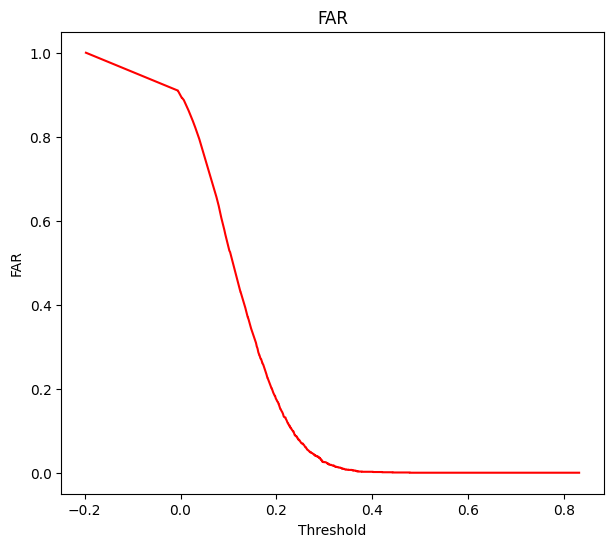

In [19]:
#thresholds = list(result.keys())
thresholds = [key for key in result.keys()]

far = [result[thresh]['FAR'] for thresh in thresholds]

plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

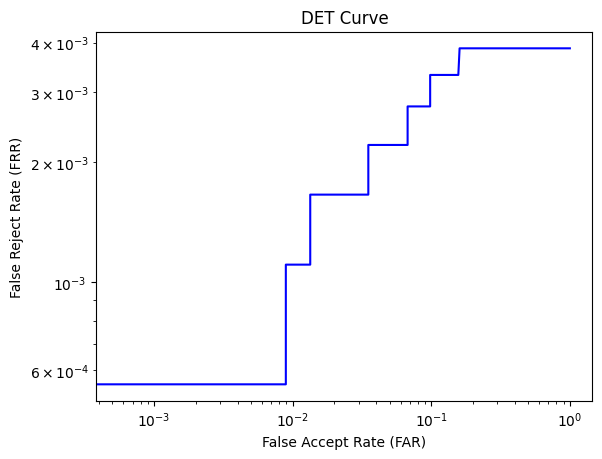

In [20]:
# Extract FAR and FRR values for plotting
thresholds = list(result.keys())
fars = [result[thresh]['FAR'] for thresh in thresholds if thresh != 'inf']
frrs = [result[thresh]['FRR'] for thresh in thresholds if thresh != 'inf']

# Since 'inf' can't be plotted, we remove it from the list of thresholds
# Also, we ensure thresholds are sorted because the plotting assumes this order
sorted_indices = np.argsort(thresholds)
fars = np.array(fars)[sorted_indices]
frrs = np.array(frrs)[sorted_indices]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()

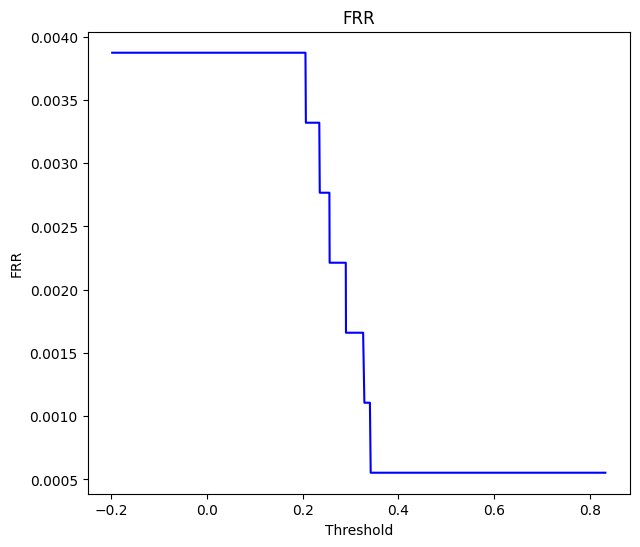

In [22]:
frr = [result[thresh]['FRR'] for thresh in thresholds]

plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

posx and posy should be finite values
/Users/jngelena/Library/Python/3.9/lib/python/site-packages/matplotlib/transforms.py:365: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


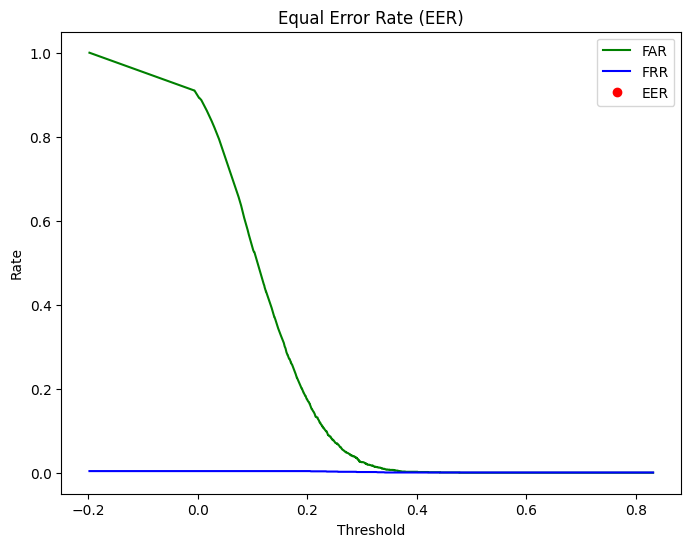

In [23]:
eer_index = np.argmin(np.abs(np.array(far) - np.array(frr)))
eer_FAR = far[eer_index]
eer_threshold = thresholds[eer_index]

# Plot FAR and FRR against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, linestyle='-', color='g', label='FAR')
plt.plot(thresholds, frr, linestyle='-', color='b', label='FRR')
plt.plot(eer_threshold, eer_FAR, 'ro', label='EER')
plt.text(eer_threshold, eer_FAR, 'EER', color='black', ha='right', va='bottom')

# Setting up the plot
plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()
